### 导入库

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from wcwidth import wcswidth
from rich.table import Table
from rich.console import Console
import seaborn as sns

In [213]:
# 处理数据集的函数
def pre_process(dataset, new_csv_file_path):
    # 定义与抑郁相关的属性
    related_attributes = [
        'Academic Pressure', 'Study Satisfaction', 'Sleep Duration', 'Financial Stress', 'Dietary Habits', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?', 'Depression'
    ]

    # 筛选出与抑郁相关的列
    dataset = dataset[related_attributes].copy()

    # 定义映射字典
    mapping_dict = {
        'Sleep Duration': {
            "'Less than 5 hours'": 4,
            "'5-6 hours'": 5.5,
            "'7-8 hours'": 7.5,
            "'More than 8 hours'": 9
        },
        'Dietary Habits': {
            'Healthy': 2,
            'Moderate': 1,
            'Unhealthy': 0
        },
        'Family History of Mental Illness': {
            'Yes': 1,
            'No': 0
        },
        'Have you ever had suicidal thoughts ?': {
            'Yes': 1,
            'No': 0
        }
    }

    # 应用映射
    for column, mapping in mapping_dict.items():
        dataset[column] = dataset[column].map(mapping)

    # 分割线
    print("-" * 50)

    # 保存修改后的数据集
    dataset.to_csv(new_csv_file_path, index=False)

    return dataset

In [214]:
csv_file_path = 'student_depression_dataset.csv'
new_csv_file_path = 'student_depression_dataset_new.csv'

# 数据预处理
original_dataset = pd.read_csv(csv_file_path, nrows=2001) # 读取前2000行数据

new_dataset = pre_process(original_dataset, new_csv_file_path)  # 预处理数据

# 删除包含 NaN 的行
new_dataset.dropna(inplace=True)

# 打印数据集
print(new_dataset)

--------------------------------------------------
      Academic Pressure  Study Satisfaction  Sleep Duration  Financial Stress  \
0                   5.0                 2.0             5.5               1.0   
1                   2.0                 5.0             5.5               2.0   
2                   3.0                 5.0             4.0               1.0   
3                   3.0                 2.0             7.5               5.0   
4                   4.0                 3.0             5.5               1.0   
...                 ...                 ...             ...               ...   
1996                3.0                 2.0             7.5               5.0   
1997                2.0                 2.0             4.0               5.0   
1998                3.0                 2.0             5.5               4.0   
1999                5.0                 1.0             7.5               5.0   
2000                3.0                 5.0             4.

In [215]:
# 训练决策树模型
# 划分特征和目标变量
X = new_dataset.drop(columns=['Depression'], axis=1)
y = new_dataset['Depression']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义参数网格
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# 创建决策树分类器
model = DecisionTreeClassifier(random_state=42)

# 使用 GridSearchCV 进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数的模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"决策树模型的准确率: {accuracy:.2f}")

最佳参数: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
决策树模型的准确率: 0.82


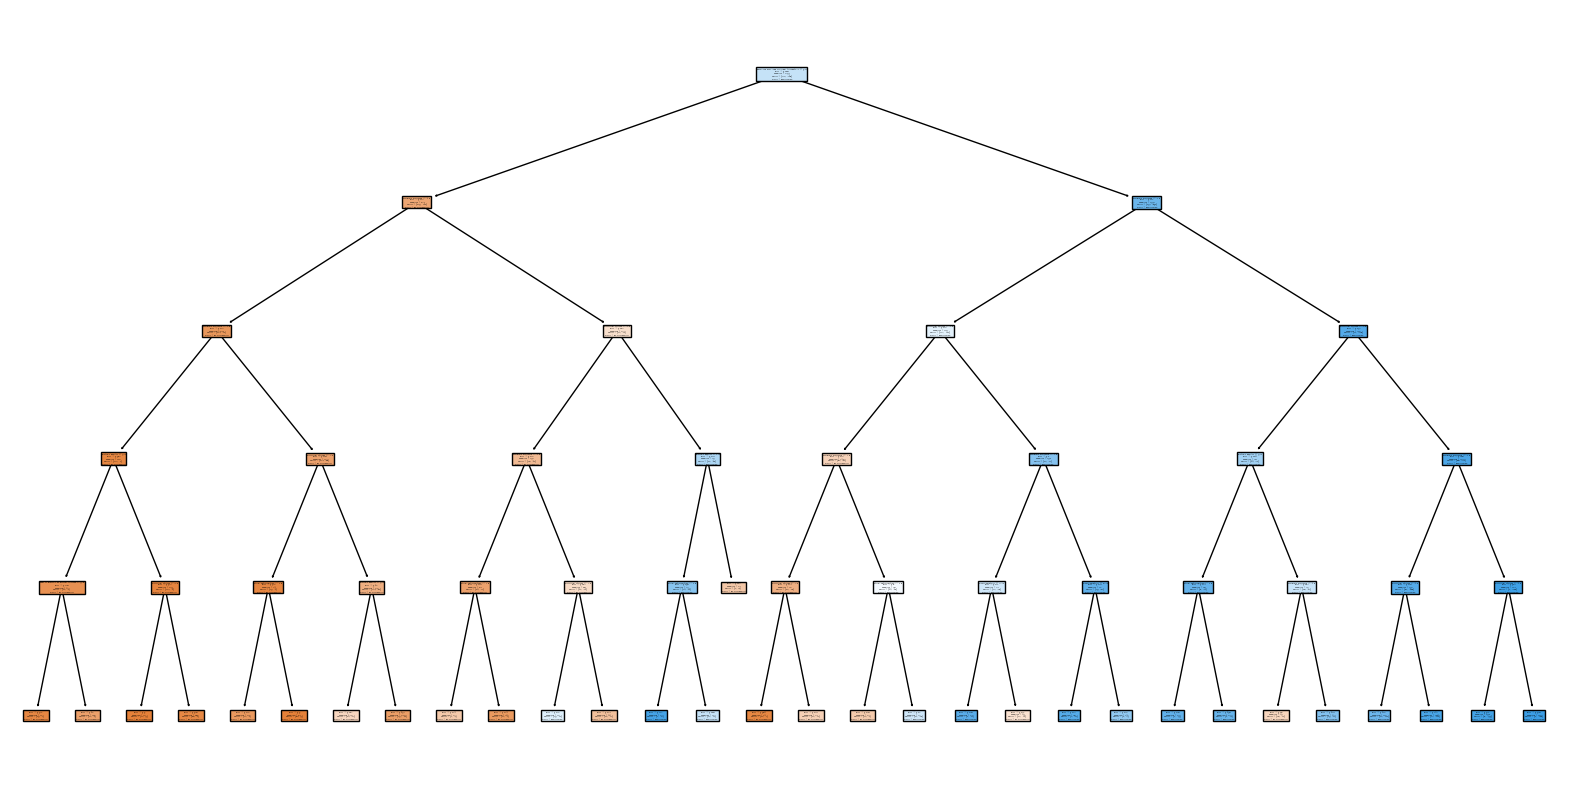

In [216]:
# 可视化决策树
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X.columns, class_names=[
          'No Depression', 'Depression'], filled=True)

# 保存为矢量图
plt.savefig('decision_tree.svg', format='svg')

plt.show()

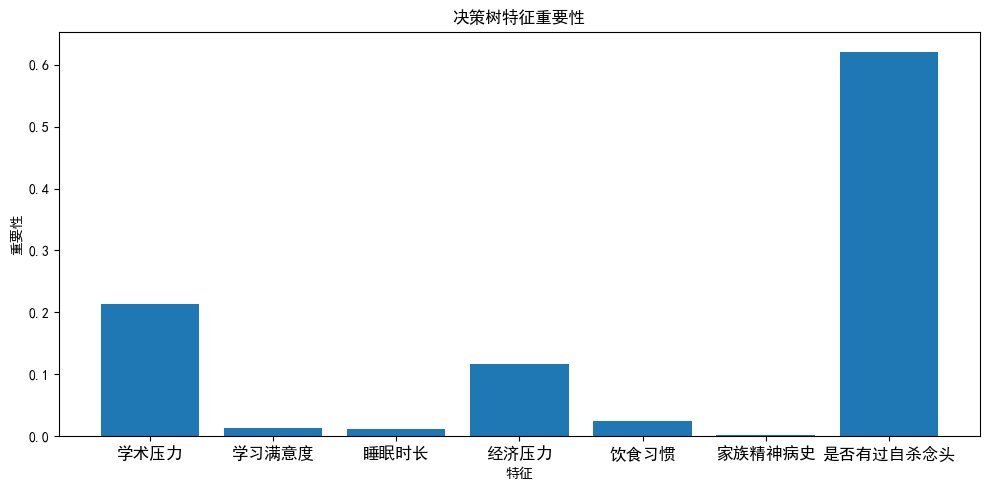

In [217]:
# 获取特征重要性
feature_importance = best_model.feature_importances_

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体，可根据系统情况修改

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 定义新标签
new_labels = ['学术压力', '学习满意度', '睡眠时长', '经济压力', '饮食习惯', '家族精神病史', '是否有过自杀念头']

# 绘制特征重要性图
plt.figure(figsize=(10, 5))
plt.bar(new_labels, feature_importance)
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('决策树特征重要性')
# 增加标签旋转角度
plt.xticks(fontsize=12)
# 自动调整布局
plt.tight_layout()
plt.show()

In [218]:
# 信息汇总
def summary_statistics(dataset):
    # 假设 target 是类别变量
    target = dataset['Depression']  # 根据实际情况修改列名
    
    dataset = dataset.drop(columns=['Depression'])  # 删除目标列以便计算统计信息
    
    # 计算每列的均值、标准差、最小值、最大值和皮尔斯相关系数
    summary = {
        'Min': dataset.min(),
        'Max': dataset.max(),
        'Mean': dataset.mean(),
        'SD': dataset.std(),
        'Class Correlation': dataset.corrwith(target)  # 计算与目标变量的相关系数
    }

    # 将汇总统计信息转换为 DataFrame
    summary_df = pd.DataFrame(summary)
    
    # 使用 Rich 表格
    print("汇总统计信息:")
    # 使用 wcwidth 处理中文字符宽度
    table = Table(show_header=True, header_style="bold magenta")
    # 添加行名列
    table.add_column("Attribute", justify="center")
    
    for col in summary_df.columns:
        table.add_column(col, justify="center")
        
    for index, row in summary_df.iterrows():
        formatted_row = [f"{x:.3f}" if isinstance(x, (int, float)) else str(x) for x in row]
        table.add_row(index, *formatted_row)

    console = Console()
    console.print(table)

In [219]:
# 汇总前4列的统计信息
summary_statistics(new_dataset)

汇总统计信息:


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃               Attribute               ┃  Min  ┃  Max  ┃ Mean  ┃  SD   ┃ Class Correlation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│           Academic Pressure           │ 1.000 │ 5.000 │ 3.157 │ 1.397 │       0.455       │
│          Study Satisfaction           │ 1.000 │ 5.000 │ 2.925 │ 1.357 │      -0.139       │
│            Sleep Duration             │ 4.000 │ 9.000 │ 6.311 │ 1.906 │      -0.076       │
│           Financial Stress            │ 1.000 │ 5.000 │ 3.147 │ 1.452 │       0.368       │
│            Dietary Habits             │ 0.000 │ 2.000 │ 0.899 │ 0.792 │      -0.165       │
│   Family History of Mental Illness    │ 0.000 │ 1.000 │ 0.490 │ 0.500 │       0.021       │
│ Have you ever had suicidal thoughts ? │ 0.000 │ 1.000 │ 0.635 │ 0.482 │       0.559       │
└───────────────────────────────────────┴───────┴───────┴───────┴───────┴───────────────────┘

### 基于规则的分类

In [220]:
# 正态化数据
def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)
    

Text(0.5, 1.0, 'Correlation Matrix of Features')

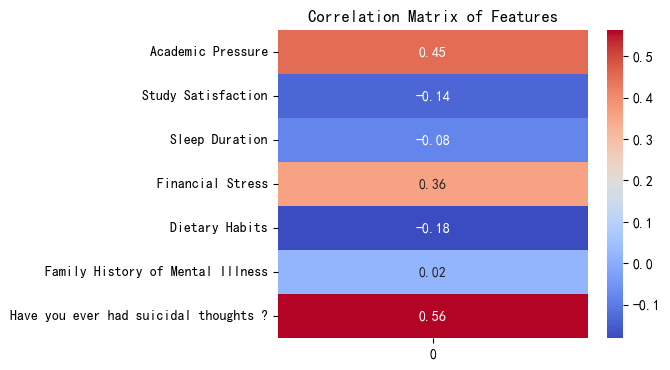

In [221]:
# 深拷贝训练集与测试集
X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()

# 标准化数据
X_train_normalized = X_train_normalized.apply(normalize_data)
X_test_normalized = X_test_normalized.apply(normalize_data)

# 计算X_train_normalized与y_train的相关系数矩阵
correlation_matrix = X_train_normalized.corrwith(y_train)

# 可视化相关系数矩阵
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')

#### 自定义规则

In [222]:
# 保留相关系数大于0.2的特征
selected_features = correlation_matrix[correlation_matrix.abs() > 0.2].index

# 保留selected_features的数据集
X_train_normalized = X_train[selected_features]
X_test_normalized = X_test[selected_features]

# 规则rule
rule = {
    '学术压力': X_train_normalized['Academic Pressure'].mean(),
    '经济压力': X_train_normalized['Financial Stress'].mean(),
    '曾经有过自杀倾向': 1
}

print(rule)

{'学术压力': 3.169375, '经济压力': 3.119375, '曾经有过自杀倾向': 1}


In [223]:
# 初始化预测结果列表
y_pred = []

# 遍历测试数据集的每一行
for index, row in X_test_normalized.iterrows():
    # 检查是否满足规则
    if (row[0] > rule['学术压力']) and (row[1] > rule['经济压力']) and (row[2] == rule['曾经有过自杀倾向']):
        # 如果满足规则，将对应的抑郁结果添加到 y_pred 中
        y_pred.append(y_test[index])
    else:
        # 如果不满足规则，可以根据具体情况处理，这里简单添加 0
        y_pred.append(0)
        
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

准确率: 0.595


### 最近邻分类
#### K临近分类器

In [224]:
# 使用K临近算法进行分类

# 创建标准化对象
scaler = StandardScaler()

# 对训练集进行标准化处理
X_train_scaled = scaler.fit_transform(X_train)

# 使用训练集的标准化参数对测试集进行标准化处理
X_test_scaled = scaler.transform(X_test)

In [225]:
# 模型训练
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', p=2)  # 创建KNN分类器对象，设置k值为5

knn.fit(X_train_scaled, y_train)  # 使用训练集数据训练模型

# 模型预测
y_pred = knn.predict(X_test_scaled)  # 使用测试集数据进行预测

# 模型评估
accuracy = accuracy_score(y_test, y_pred)  # 计算准确率
print("Accuracy:", accuracy)

# 打印分类报告，使用 rich 表格包含精确率、召回率、F1 值等信息
print("分类报告:")
table = Table(show_header=True, header_style="bold magenta")
table.add_column("Accuracy rate", justify="center")
table.add_column("Recall rate", justify="center")
table.add_column("F1 score", justify="center")

# 计算每个类别的精确率、召回率、F1 值和支持度
report = classification_report(y_test, y_pred, output_dict=True)

# 遍历每个类别并添加到表格中
for class_label, metrics in report.items():
    if class_label == "accuracy":  # 跳过总准确率
        continue
    precision = metrics["precision"]
    recall = metrics["recall"]
    f1_score = metrics["f1-score"]
    table.add_row(
        f"{precision:.4f}",
        f"{recall:.4f}",
        f"{f1_score:.4f}",
    )

# 打印表格
console = Console()
console.print(table)

Accuracy: 0.8175
分类报告:


┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Accuracy rate ┃ Recall rate ┃ F1 score ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━┩
│    0.7679     │   0.7914    │  0.7795  │
│    0.8534     │   0.8354    │  0.8443  │
│    0.8107     │   0.8134    │  0.8119  │
│    0.8186     │   0.8175    │  0.8179  │
└───────────────┴─────────────┴──────────┘

### 贝叶斯分类

In [226]:
# 创建高斯朴素贝叶斯分类器
gnb = GaussianNB()

# 使用训练集数据训练模型
gnb.fit(X_train, y_train)

# 使用测试集数据进行预测
y_pred = gnb.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy:.2f}")

模型准确率: 0.82
